In [1]:
# MOD per system
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck') 


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# 1 Functions

## 1.1 Make Examples
1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
2) Build Semi-Analytic-Model with super simple parameters 
3) Get SAM edges and numbers as in sam.gwb()

In [2]:
def example(dur, cad, mtot, mrat, redz, print_test):
    ''' 
    1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
    2) Build Semi-Analytic-Model with super simple parameters 
    3) Get SAM edges and numbers as in sam.gwb()

    Parameters
    ----------
    dur : 
    cad :
    mtot :
    mrat :
    redz : 
    print_test :

    Returns
    -------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-a, Q-1, Z-1, F-1) array
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    fobs : (F-1) array
        observed frequency bin centers
    '''
    # 1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
    fobs = utils.nyquist_freqs(dur,cad)
    fobs_edges = utils.nyquist_freqs_edges(dur,cad)
    if(print_test):
        print(f"Number of frequency bins: {fobs.size-1}")
        print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
        print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

    # 2) Build Semi-Analytic-Model with super simple parameters 
    sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
    if(print_test):
        print('edges:', sam.edges)
    # get observed orbital frequency bin edges and centers 
    # from observed GW frequency bin edges
    fobs_orb_edges = fobs_edges / 2.0 # f_orb = f_GW/2
    fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

    # 3) Get SAM edges and numbers as in sam.gwb()
    # dynamic_binary_number
    # gets differential number of binaries per bin-vol per log freq interval
    edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
    edges[-1] = fobs_orb_edges

    # integrate (multiply by bin volume) within each bin
    number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
    number = number * np.diff(np.log(fobs_edges))

    return edges, number, fobs

Example 2

In [3]:
def example2(print_test = True, exname='Example 2'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    
    dur = 5.0*YR/3.1557600
    cad = .5*YR/3.1557600
    
    mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
    mrat=(1e-1, 1.0, 2)
    redz=(1e-3, 1.0, 4)
    
    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

Example 3

In [4]:
def example3(print_test = True, exname = 'Example 3'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    dur = 5.0*YR/3.1557600
    cad = .5*YR/3.1557600
    

    mtot=(1.0e6*MSOL/1.988409870698051, 4.0e9*MSOL, 25)
    mrat=(1e-1, 1.0, 25)
    redz=(1e-3, 10.0, 25)

    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

Example 4

In [5]:
def example4(print_test = True, exname = 'Example 4'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    dur = 5.0*YR/3.1557600
    cad = .2*YR/3.1557600

    mtot=(1.0e6*MSOL/1.988409870698051, (4.0e11*MSOL).astype(np.float64), 25)
    mrat=(1e-1, 1.0, 25)
    redz=(1e-3, 10.0, 25)
    
    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

## 1.2 SS Calculations

ss_gws_by_loops \
rounds loops first

In [31]:
def ss_gws_by_loops(edges, number, realize=False, round=True, ss=True, 
                    sum=True, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
    ss : bool 
        Whether or not to separate the loudest single source in each frequency bin.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc_bg : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)
    hc_ss : (F-1) array
        The characteristic strain of the loudest single source at each frequency.
    sspar : (F-1, 3) 2darray or None
        The parameters (M, q, and z) of the loudest single source at each frequency.
        None if ss = False. 
    ssidx : (F-1, 3) 2darray or None
        The indices (m_idx, q_idx, and z_idx) of the parameters of the loudest single
        source's bin, at each frequency.    
        None if ss = False. 
    maxhs : (F-1) array or None
        The maximum single source strain amplitude at each frequency.
        None if ss = False. 
    bgnum : (M-1, Q-1, Z-1, F-1) 
        The number of binaries in each bin after the loudest single source
        at each frequency is subtracted out.

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    
    # GW background characteristic strain
    hc_bg = np.empty_like(number)

    # new number array
    if(round == True):
        bgnum = np.copy(np.floor(number).astype(int))
        if(print_test):
            print('noninteger bgum values:', bgnum[np.where(bgnum%1 !=0)])
    else:
        bgnum = np.copy(number)

    # for single sources, make a grid with shape
    # (f, 3)
    if(ss == True):
        # params of loudest bin with number>=1
        # shape (f,3) for 3 params
        sspar = np.empty((len(fc), 3)) 
        # param indices of loudest bin with number>=1
        # shape (f,3) for 3 params
        ssidx = np.empty((len(fc), 3)) 
        # max hs at each frequency
        maxhs = np.zeros(len(fc))
        # (max)  single source characteristic strain at each frequency
        hc_ss = np.zeros(len(fc))
    else: 
        sspar = None
        ssidx = None
        maxhs = None
        hc_ss = None

    # # not worrying about realization implementation yet
    # # for r realizations, make a grid with shape 
    # # m, q, z, f, r
    # if(utils.isinteger(realize)):
    #     newshape = hc_grid.shape + (realize,)
    #     if(print_test):
    #         print('newshape:', newshape)
    #     realized_grid = np.empty(newshape)


    # --------------- Single Sources ------------------
    # 0) Round or realize so numbers are all integers
    # 1) Identify the loudest (max hs) single source in a bin with N>0 
    # 2) Record the parameters, parameter indices, and strain
    #  of that single source
    # 3) Subtract 1 from the number in that source's bin, 
    # 4) Calculate single source characteristic strain (hc)
    # 5) Calculate the background with the new number 
    
    if(ss == True):
        for m_idx in range(len(mt)):
            for q_idx in range(len(mr)):
                cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
                for z_idx in range(len(rz)):
                    cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                    
                    # print M, q, z, M_c, d_c
                    if(print_test):
                        print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                            (mt[m_idx], mr[q_idx], rz[z_idx]))
                        print('\t m_c = %.2e, d_c = %.2e' 
                            % (cmass, cdist))

                    # check if loudest source in any bin
                    for f_idx in range(len(fc)):
                        rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                        # hs of a source in that bin
                        hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                        
                        # 1) IF LOUDEST
                        # check if loudest hs at that 
                        # frequency and contains binaries
                        if(hs_mqzf>maxhs[f_idx] and 
                           bgnum[m_idx, q_idx, z_idx, f_idx]>0):
                            if(bgnum[m_idx, q_idx, z_idx, f_idx]<1):
                                print('number<1 used', bgnum[m_idx, q_idx, z_idx, f_idx])  #DELETE
                            # 2) If so, RECORD:
                            # parameters M, q, z
                            sspar[f_idx] = np.array([mt[m_idx], mr[q_idx],
                                                     rz[z_idx]])
                            # parameter indices
                            ssidx[f_idx] = np.array([m_idx, q_idx, z_idx])
                            # new max strain
                            maxhs[f_idx] = hs_mqzf

                    # print fr, hs, hc^2/dlnf, number, hc
                    # if(print_test):
                    #     print('\tfr = %.2fnHz, h_s = %.2e'
                    #         % (rfreq*10**9, hs_mqzf))
                    #     print('\t\tnumber: %.2e' % 
                    #           number[m_idx, q_idx, z_idx, f_idx])
                    #     if(ss):
                    #         print('\t\thsmax = %.2e, max indices = (%d,%d,%d)' 
                    #             % (maxhs[f_idx], ssidx[f_idx,0], 
                    #                ssidx[f_idx,1], ssidx[f_idx,2]))

        # 3) SUBTRACT 1 
        # from bin with loudest source at each frequency
        # can do this using the index of loudest, ssidx
        # recall ssidx has shape [3, F]
        # and = [(m_idx,q_idx,z_idx), fc],
        for f_idx in range(len(fc)):
            bgnum[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), 
                    f_idx] -= 1 
            # print('ssidx=', int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), f_idx)
            # print(bgnum.shape)
            # print(bgnum[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), f_idx])

            # 4) CALCULATE 
            # single source characteristic strain
            hc_ss[f_idx] = np.sqrt(maxhs[f_idx]**2 * (fc[f_idx]/df[f_idx]))
        
        # CHECK no numbers should be <0 
        if(np.any(bgnum<0)): 
            error_index = np.where(bgnum<0)
            print('number<0 found at (M,q,z,f) =', error_index)         
        

    # 5)
    # ----------------- Calculate Background Strains --------------------
    # then we can go back in and calculate characteristic strains
    # NOTE: could make this faster by saving rfreq and hs values from above
    # instead of recalculating
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    if(realize == False):
                        hc_bg[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * bgnum[m_idx, q_idx, z_idx, f_idx])
                    else: 
                        print('realize not implemented yet') 
                        return 0   
                    # elif(realize == True):
                    #     hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(bgnum[m_idx, q_idx, z_idx, f_idx]))
                    # elif(utils.isinteger(realize)):
                    #     for r_idx in range(realize):
                    #         realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                    #             np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(bgnum[m_idx, q_idx, z_idx, f_idx]))
                    #     hc_grid = realized_grid                
                    # else:
                    #     print("`realize` ({}) must be one of {{True, False, integer}}!"\
                    #         .format(realize))

                    if(print_test):
                        print('\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % bgnum[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_bg[m_idx, q_idx, z_idx, f_idx])
                        if(ss == True):
                            print('\t\t loudest?', 
                                np.all((ssidx[f_idx] == np.array([m_idx, q_idx, z_idx]))))
    if(ss and print_test):
        print('----loudest bins:')
        for f_idx in range(len(fc)):
            print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
                    % (sspar[f_idx,0], sspar[f_idx,1], sspar[f_idx,2], fc[f_idx]))
            # if we use this instead, we don't need sspar
            # print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
            #       % (mt[ssidx[f_idx,0]], mr[ssidx[f_idx,1]], rz[ssidx[f_idx,2]]))

     
    if(sum):
        # sum over all bins at a given frequency and realization
        hc_bg = np.sqrt(np.sum(hc_bg**2, axis=(0, 1, 2)))

    
    return hc_bg, hc_ss, sspar, ssidx, maxhs, bgnum


gws_by_ndars (no ss)

In [7]:
def gws_by_ndars(edges, number, realize, round = True, sum = True, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions 
        correspond to total mass, mass ratio, redshift, and observer-frame orbital 
        frequency. The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated 
        by integrating `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
        NOTE: should add a warning if round and realize are both True
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hchar : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)

    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)

    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])

    # Sample:
    if(realize == False):
        # without sampling, want strain in shape (M-1, Q-1, Z-1, F-1)
        if(round): 
            # discretize by rounding number down to nearest integer 
            hchar *= np.floor(number).astype(int) 
        else: 
            # keep non-integer values
            hchar *= number

    if(realize == True):
        # with a single sample, want strain in shape (M-1, Q-1, Z-1, F-1)
        hchar *= np.random.poisson(number)

    if(utils.isinteger(realize)):
        # with R realizations, 
        # to get strain in shape (M-1, Q-1, Z-1, F-1, R) we need
        # hchar in shape(M-1, Q-1, Z-1, F-1, 1)
        # Poisson sample in shape (1, 1, 1, 1, R)
        npois = np.random.poisson(number[...,np.newaxis], size = (number.shape + (realize,)))
        if(print_test):
            print('npois', npois.shape)
        hchar = hchar[...,np.newaxis] * npois


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    return np.sqrt(hchar)

subtraction from number method

In [8]:
def subtract_from_number(bgnum, ssidx):
    ''' 
    Inefficient way to subtract 1 from the number of all bins 
    with a loudest single source
    
    Paramaters
    -------------
    bgnum : (M, Q, Z, F) array
        number of sources in each bin, before
        single sources have been subtracted
    ssidx : (F, 4) array 
        The indices (m_idx, q_idx, and z_idx) of the parameters of the 
        loudest single source's bin, at each frequency

    Returns
    -------------
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin,
        after single sources have been subtracted
    '''

    for ff in range(len(ssidx)):
        m,q,z,f = ssidx[ff]
        print(m,q,z,f)
        bgnum[m,q,z,f] -=1
    return bgnum

ss_gws_by_ndars

In [9]:
def ss_gws_by_ndars(edges, number, realize, round = True, sum = True, 
                    ss = True, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated


    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
        Does nothing if realize is True.
    ss : bool 
        Whether or not to separate the loudest single source in each frequency bin.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc_bg : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)
    hc_ss : (F-1) array
        The characteristic strain of the loudest single source at each frequency.
    ssidx : (F-1, 4) 2darray or None
        The indices (m_idx, q_idx, and z_idx) of the parameters of the loudest single
        source's bin, at each frequency such that 
        ssidx[i,0] = m_idx of the ith frequency
        ssidx[i,1] = q_idx of the ith frequency
        ssidx[i,2] = z_idx of the ith frequency
        ssidx[i,3] = f_idx of the ith frequency = i
        in order of largest to smallest strain amplitude 
        (NOT in order of lowest to highest frequency)
        None if ss = False. 
    maxhs : (F-1) array or None
        The maximum single source strain amplitude at each frequency.
        None if ss = False. 
    bgnum : (M-1, Q-1, Z-1, F-1) 
        The number of binaries in each bin after the loudest single source
        at each frequency is subtracted out.

        

    Potential BUG: In the unlikely scenario that there are two equal hsmaxes 
    (at same OR dif frequencies), ssidx calculation will go wrong
    Could avoid this by using argwhere for each f_idx column separately.
    Or TODO implement some kind of check to see if any argwheres return multiple 
    values for that hsmax and raises a warning/assertion error
    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)


    ############################################################
    ########## HERE'S WHERE THINGS CHANGE FOR SS ###############
    ############################################################

    # --------------- Single Sources ------------------
    ##### 0) Round and/or realize so numbers are all integers
    if (round == True):
        bgnum = np.copy(np.floor(number).astype(int))
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with round=True'
    else:
        bgnum = np.copy(number)
        if(ss==True):
            warnings.warn('Number grid used for single source calculation.')

    if(realize == True):
        bgnum = np.random.poisson(number)
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'

    #### 1) Identify the loudest (max hs) single source in a bin with N>0 
    hsamp[np.where(bgnum==0)] = 0 #set hs=0 if number=0
    
    # --- Single Source Strain Amplitude At Each Frequency ---
    # to get max strain in shape (F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1), search over first 3 axes
    hsmax = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
    
    #### 2) Record the indices and strain of that single source

    # --- Indices of Loudest Bin ---
    # Shape (F-1, 4), looks like
    # [[m_idx,q_idx,z_idx,0],
    #  [m_idx,q_idx,z_idx,1],
    #   ........
    #  [m_idx,q_idx,z_idx,F-2]]
    ssidx = np.argwhere(hsamp==hsmax) # BUG
    ssidx = ssidx[ssidx[:,-1].argsort()]



    # 3) Subtract 1 from the number in that source's bin, 
    #       (Check no numbers are <0 after)
    # --- Background Number ---
    # bgnum = subtract_from_number(bgnum, ssidx) # Find a better way to do this!
    bgnum[np.where(hsamp == hsmax)]-=1 # better way found! ssidx may be unnecessary now, but still nice to have

    assert np.all(bgnum>=0), f"bgnum contains negative values at: {np.where(negs<0)}"
    # if(np.any(bgnum<0)):   # alternate way to check for this error, and give index of neg number
    #         error_index = *np.where(bgnum<0)
    #         print('number<0 found at [M's], [q's], [z's], [f's]) =', error_index)   

    

    # 4) Calculate single source characteristic strain (hc)
    # --- Single Source Characteristic Strain ---
    # to get ss char strain in shape [F-1] need
    # fc in shape (F-1)
    # df in shape (F-1)
    hc_ss = np.sqrt(hsmax**2 * (fc/df))
    # return hc_ss, hsamp, hsmax, ssidx, bgnum

    # 5) Calculate the background with the new number 
    ############### SAME AS BEFORE ############################
    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])
    
    if (realize==False):
        hchar *= bgnum
    else:
        print('realize not implemented yet') 
        return 0


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    hc_bg = np.sqrt(hchar)

    return hc_bg, hc_ss, hsamp, hsmax, ssidx, bgnum

## Test Functions
Consider changing all the np.all(x==y) to np.isclose(x,y)

In [48]:
def max_test(hsmax, hsamp): 
    # check hsmaxes are correct
    hsmax_hsamp_match = np.empty_like(hsmax)
    for f_idx in range(len(hsmax)):
        hsmax_hsamp_match[f_idx] = (np.max(hsamp[...,f_idx]) == hsmax[f_idx])
    assert np.all(hsmax_hsamp_match == True), "the max amplitudes in hsamp do not match those in hsmax"
    print('max_test passed')

def ssidx_test(hsmax, hsamp, ssidx, print_test):
    # check ssidx are correct and in frequency order
    for i in range(len(hsmax)): #ith frequency
        m,q,z,f = ssidx[i]
        assert i==f, 'ssidx not in order of frequencies'
        if(print_test):
            print('max is at m,q,z,f = %d, %d, %d, %d and it = %.2e'
                  % (m, q, z, f, hsmax[i]))
        assert (hsamp[m,q,z,f] == hsmax[i]), f"The ssidx[{i}] does not give the hsmax[{i}]."
    print('ssidx test passes')

def subtract_from_number(bgnum, ssidx):
    ''' 
    Inefficient way to subtract 1 from the number of all bins 
    with a loudest single source
    
    Paramaters
    -------------
    bgnum : (M, Q, Z, F) array
        number of sources in each bin, before
        single sources have been subtracted
    ssidx : (F, 4) array 
        The indices (m_idx, q_idx, and z_idx) of the parameters of the 
        loudest single source's bin, at each frequency

    Returns
    -------------
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin,
        after single sources have been subtracted
    '''

    for ff in range(len(ssidx)):
        m,q,z,f = ssidx[ff]
        bgnum[m,q,z,f] -=1
    return bgnum

def number_test(num, bgnum, fobs, exname='', plot_test=False):
    ''' 
    Plots num - bgnum, where number is the ndarray of 
    integer number of sources in each bin, i.e. after 
    rounding or Poisson sampling

    Parameters
    ------------
    num : (M, Q, Z, F) array
        integer numbers in each bin, i.e. after rounding or
        Poisson sampling
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin, 
        after single source subtraction
    fobs : (F) array
        frequencies of each F, for ax titles
    exname : String
        name of example
    plot_test : Bool
        whether or not to print values a


    Returns
    -----------
    None 
    
    '''   
    if np.all(num%1 == 0) != True: warnings.warn("num contains at least one non-integer value")
    difs = num - bgnum
    assert len(difs[np.where(difs>0)]) == len(difs[0,0,0,:]), "More than one bin per frequency found with a single source subtracted."

    if(plot_test):
        fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
        fig.suptitle('integer number - numbg for each bin, '+ exname)
        ax[0].set_ylabel('number - number_bg')
        bins = np.arange(0, num[...,0].size, 1)
        bins = np.reshape(bins, num[...,0].shape)
        # print(bins.shape)
        # print(num[...,0].shape)
        for f in range(len(fobs)):
            ax[f].scatter(bins, (num[...,f] - bgnum[...,f]))
            ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % (fobs[f]*10**9))
            ax[f].set_xlabel('bin')
        fig.tight_layout()
    print('number test passed')

    
    # TODO Assertion 

def compare_to_loops(edges, number, hc_bg, hc_ss, hsmax, ssidx, bgnum):
    hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, number_bg_loop \
      = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True, print_test=False)
    
    for i in range(len(ssidx)):
        assert np.all(ssidx[i, 0:3] == ssidx_loop[i,:]), f"ssidx[{i}] by ndars does not match by loops"
    assert (np.all(bgnum == number_bg_loop)), "bgnum by ndars does not match by loops"
    assert (np.all(hc_ss == hc_ss_loop)), "hc_ss by ndars does not match by loops"    
    assert (np.all(hsmax == maxhs_loop)), "hsmax by ndars does not match by loops" 
    assert (np.all(hsmax == maxhs_loop)), "hsmax by ndars does not match by loops"
    assert (np.isclose(hc_bg, hc_bg_loop, atol=1e-30, rtol=1e-30))
    print('comparison to loops passed')


def run_example_test(edges,number, fobs, exname='', print_test=False, 
                     loop_comparison = True):
    '''
    Call tests for some edges, number
    Returns
    ------
    hsamp
    hsmax
    ssidx
    bgnum
    '''
    hc_bg, hc_ss, hsamp, hsmax, ssidx, bgnum = ss_gws_by_ndars(edges, number, realize=False, round=True, ss=True, sum=True)
    max_test(hsmax, hsamp)

    ssidx_test(hsmax, hsamp, ssidx, print_test)

    rounded = np.floor(number).astype(int)
    number_test(rounded, bgnum, fobs, exname, plot_test=print_test)
    
    if(loop_comparison): # optional because its faster without
        compare_to_loops(edges, number, hc_bg, hc_ss, hsmax, ssidx, bgnum)

    return hc_bg, hc_ss, hsamp, hsmax, ssidx, bgnum

In [66]:
edges, number, fobs, exname = example4(print_test=False)
hc_bg, hc_ss, hsamp, hsmax, ssidx, bgnum = \
    run_example_test(edges, number, fobs, exname, print_test=False)

max_test passed
ssidx test passes
number test passed
comparison to loops passed


In [67]:
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, number_bg_loop \
  = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True, print_test=False)
    

In [71]:
np.set_printoptions(precision=2)
print('isequal:', hc_bg == hc_bg_loop)
print('isclose:', np.isclose(hc_bg, hc_bg_loop, atol=1e-30, rtol=1e-30))

diff = hc_bg - hc_bg_loop
error = diff/hc_bg_loop
# np.isclose(hc_tt, )
print('diff:', diff)
print('percent diff:', error)
print('hc_bg:', hc_bg)
print('hc_bg_loop:', hc_bg_loop)

isequal: [False False  True False False False False False False False False False]
isclose: [ True  True  True  True  True  True  True  True  True  True  True  True]
diff: [ 3.94e-31  9.86e-32  0.00e+00 -4.93e-32  1.23e-32 -2.47e-32 -6.16e-33
 -6.16e-33  6.16e-33 -6.16e-33 -3.08e-33 -6.16e-33]
percent diff: [ 3.61e-16  2.32e-16  0.00e+00 -3.55e-16  1.29e-16 -3.73e-16 -1.21e-16
 -1.58e-16  1.96e-16 -2.41e-16 -1.49e-16 -2.94e-16]
hc_bg: [1.09e-15 4.25e-16 2.25e-16 1.39e-16 9.54e-17 6.61e-17 5.11e-17 3.90e-17
 3.14e-17 2.56e-17 2.06e-17 2.10e-17]
hc_bg_loop: [1.09e-15 4.25e-16 2.25e-16 1.39e-16 9.54e-17 6.61e-17 5.11e-17 3.90e-17
 3.14e-17 2.56e-17 2.06e-17 2.10e-17]


## Max Index Functions

In [291]:
def max_index_at_f(grid):
    """ Get the index of the maximum value for each frequency. 
    Frequency is the 4th dimension of the 4Darray, grid.
    NOTE: Find a more elegant way to do this with some fancy indexing! Or
    at least choose which option works best and just use that

    Parameters:
    grid : [M,Q,Z,F] array
        test grid

    Returns:
    mqz_f : (3, F) array
        Indices of max grid value at each frequency
        For F frequencies, it looks like 
        [[m1,m2,...,mF], [q1,q2,...,qF], [z1,z2,...,zF]] 
    f_mqz : (F, 3) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    all_f : (4, F) array
        Indices of max grid value at each frequency
        For n frequencies, it looks like 
        [[m1,m2,...,mF], [q1,q2,...,qF], [z1,z2,...,zF], [1,2,...,F]] 
    f_all : (F, 4) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    """
    mqz_f = np.empty((3,len(grid[0,0,0,:])))
    f_mqz = np.empty((len(grid[0,0,0,:]),3))
    all_f = np.empty((4, len(grid[0,0,0,:])))
    f_all = np.empty((len(grid[0,0,0,:]),4))

    for f_idx in range(len(grid[0,0,0,:])):
        m,q,z = np.unravel_index(np.argmax(grid[...,f_idx]), 
                                 grid[...,f_idx].shape)
        mqz_f[:,f_idx] = np.array([m,q,z])
        f_mqz[f_idx,:] = np.array([m,q,z])
        all_f[:, f_idx] = np.array([m,q,z,f_idx])
        f_all[f_idx,:] = np.array([m,q,z,f_idx])
    mqz_f = mqz_f.astype(int)
    f_mqz = f_mqz.astype(int)
    all_f = all_f.astype(int)
    f_all = f_all.astype(int)
    return mqz_f, f_mqz, all_f, f_all

def argwhere_at_f(grid):
    """ Get the index of the maximum value for each frequency. 
    Frequency is the 4th dimension of the 4Darray, grid.
    NOTE: This should match f_all

    Parameters:
    grid : [M,Q,Z,F] array
        test grid

    Returns:
    argwhere : (F, 4) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    
    """
    maxes = np.max(grid, axis=(0,1,2))
    # print(maxes)
    argwhere = np.argwhere(grid==maxes)
    # print(argwhere)
    return argwhere


In [7]:
def test_argwhere(hsmax, hsamp):
    # check argwhere find max indices correctly
    f_all = (max_index_at_f(grid))[-1]
    argwhere = argwhere_at_f(grid)
    assert (np.all(f_all == argwhere)), 'argwhere failing to find correct max indices'


## Scratch
- matching max values from hsmax, hsamp, and ssidx
- number-bgnum give 1 nonzero value for each frequency
- hc_bg^2 + hc_ss^2 = hc_tt^2

In [399]:
np.set_printoptions(precision=2)
hsamp, hsmax, ssidx, bgnum = ss_gws_by_ndars(edges, number, realize=False, round=True, ss=True, sum=True)
#### Test hsmax
for i in range(len(hsmax)):
    print(np.max(hsamp[...,i]) == hsmax[i])
# print(np.max(hsamp[...,0]))
# print(hsmax)
# print(number>=1)

### Test ssidx
print(ssidx)
print(ssidx.shape)
for f_idx in range(len(hsamp[0,0,0,:])):
    print(f_idx)
    print(hsamp[ssidx[f_idx,0], ssidx[f_idx,1], ssidx[f_idx,2], ssidx[f_idx,3]])
    print(hsmax[f_idx])
    print(np.max(hsamp[...,f_idx]))
    # Those should all be equal, lets make this into asserts
print(hsamp.shape)
# BUG: ssidx does not give the correct maxes for the more complicated exampleS (3 and 4)

True
True
True
True
True
True
True
True
True
True
True
True
[[13 23 16  0]
 [12 23 18  1]
 [10 23 16  2]
 [10 23 18  3]
 [ 9 23 17  4]
 [ 8 23 16  5]
 [ 8 23 17  6]
 [ 8 23 18  7]
 [ 7 23 17  8]
 [ 7 23 17  9]
 [ 6 23 16 10]
 [ 7 23 18 11]]
(12, 4)
0
1.0051787086385068e-16
1.0051787086385068e-16
1.0051787086385068e-16
1
4.3250770488997604e-17
4.3250770488997604e-17
4.3250770488997604e-17
2
1.2332171467578702e-17
1.2332171467578702e-17
1.2332171467578702e-17
3
1.040297297960971e-17
1.040297297960971e-17
1.040297297960971e-17
4
5.478025031806371e-18
5.478025031806371e-18
5.478025031806371e-18
5
2.966218754178506e-18
2.966218754178506e-18
2.966218754178506e-18
6
2.6685858687611787e-18
2.6685858687611787e-18
2.6685858687611787e-18
7
2.5021946566713723e-18
2.5021946566713723e-18
2.5021946566713723e-18
8
1.2282383135442348e-18
1.2282383135442348e-18
1.2282383135442348e-18
9
1.3176122816587554e-18
1.3176122816587554e-18
1.3176122816587554e-18
10
6.732469961608836e-19
6.732469961608836e-19
6.7

In [401]:
bgnum = np.floor(number).astype(int) 
print(np.shares_memory(bgnum, number))

False


In [402]:
arr = np.array([[[1,2], [3,4], [5,6], [1,2]], [[9000,20], [30,40], [50,60], [10,20]], [[100,200], [300,400], [500,600], [700,800]]])
# arr, like hsamp, shape (3,4,2)
print(arr.shape, np.max(arr[...,0]), np.max(arr[...,1]))
maxes = np.amax(arr, axis=(0,1)) 
# maxes, like hsmax, shape 2
print(maxes.shape)
print(arr[np.where(arr==maxes)])
idx = np.array(np.where(arr==maxes))
print('index', idx.shape, '\n', idx)
rot = np.swapaxes(idx,0,1)
print('rot', rot.shape, '\n', rot)
for i in range(2):
    print(arr[int(idx[0,i]), int(idx[1,i]), int(idx[2,i])])
for i in range(2):
    print(arr[int(rot[i,0]), int(rot[i,1]), int(rot[i,2])])

(3, 4, 2) 9000 800
(2,)
[9000  800]
index (3, 2) 
 [[1 2]
 [0 3]
 [0 1]]
rot (2, 3) 
 [[1 0 0]
 [2 3 1]]
9000
800
9000
800


here's how to check

In [404]:
hsmax_hsamp_match = np.empty_like(hsmax)
hsmax_ssidx_match = np.empty_like(hsmax)
for f_idx in range(len(hsmax)):
    hsmax_hsamp_match[f_idx] = (np.max(hsamp[...,f_idx]) == hsmax[f_idx])
    
    m,q,z,f = (ssidx[np.where(ssidx[:,3] == f_idx)])[0]
    print(m,q,z,f)
    hsmax_ssidx_match[f_idx] = (hsamp[m,q,z,f] == hsmax[f_idx])
assert np.all(hsmax_hsamp_match == True), "the max amplitudes in hsamp do not match those in hsmax"
assert np.all(hsmax_ssidx_match == True), "the max amplitudes in hsamp idenfitied with ssidx do not match those in hsmax"

13 23 16 0
12 23 18 1
10 23 16 2
10 23 18 3
9 23 17 4
8 23 16 5
8 23 17 6
8 23 18 7
7 23 17 8
7 23 17 9
6 23 16 10
7 23 18 11


In [ ]:
# to look up where the strain at some index (e.g. from ssidx):
f=3
print(ssidx[np.where(ssidx[:,3] == f)])

[[10 23 18  3]]


In [ ]:
print(ssidx[0,...])
print(ssidx)
print(ssidx[:,3])
# print(number.shape)
# print(hsmax)


[ 6 23 16 10]
[[ 6 23 16 10]
 [ 7 23 17  8]
 [ 7 23 17  9]
 [ 7 23 18 11]
 [ 8 23 16  5]
 [ 8 23 17  6]
 [ 8 23 18  7]
 [ 9 23 17  4]
 [10 23 16  2]
 [10 23 18  3]
 [12 23 18  1]
 [13 23 16  0]]
[10  8  9 11  5  6  7  4  2  3  1  0]


In [ ]:
print(hsmax_hsamp_match)
print(hsmax_ssidx_match)

[1. 1. 1. 1. 1.]
[0. 0. 1. 0. 0.]


In [406]:
hsmaxes = np.max(hsamp, axis=(0,1,2))
print(hsmaxes) # this orders them from largest to smallest
argwhere = np.argwhere(hsamp==hsmaxes)
revwhere = np.argwhere(hsmaxes==hsamp) # order makes no dif
print(argwhere)
print(revwhere)
print(np.all(argwhere==revwhere))
print(hsmaxes[0])
print(np.max(hsmax))
print(hsamp[13,23,16,0])

[1.01e-16 4.33e-17 1.23e-17 1.04e-17 5.48e-18 2.97e-18 2.67e-18 2.50e-18
 1.23e-18 1.32e-18 6.73e-19 1.31e-18]
[[ 6 23 16 10]
 [ 7 23 17  8]
 [ 7 23 17  9]
 [ 7 23 18 11]
 [ 8 23 16  5]
 [ 8 23 17  6]
 [ 8 23 18  7]
 [ 9 23 17  4]
 [10 23 16  2]
 [10 23 18  3]
 [12 23 18  1]
 [13 23 16  0]]
[[ 6 23 16 10]
 [ 7 23 17  8]
 [ 7 23 17  9]
 [ 7 23 18 11]
 [ 8 23 16  5]
 [ 8 23 17  6]
 [ 8 23 18  7]
 [ 9 23 17  4]
 [10 23 16  2]
 [10 23 18  3]
 [12 23 18  1]
 [13 23 16  0]]
True
1.0051787086385068e-16
1.0051787086385068e-16
1.0051787086385068e-16


grid:

1x  |  xx  |  xx  |  xx  |  xx \
xx  |  9x  |  x3  |  xx  |  xx \
xx  |  xx  |  xx  |  x4  |  x5 

In [310]:
grid = np.array([[[[1,0,0,0,0],[0,9,0,0,0],[0,0,0,0,0]]],
                 [[[0,0,0,0,0],[0,0,3,0,0],[0,0,0,4,5]]]])
print(grid.shape)
mqz_f, f_mqz, all_f, f_all= max_index_at_f(grid)
print('mqz_f:\n',mqz_f)
print('\nf_mqz:\n', f_mqz)
print('\nall_f:\n', all_f)
print('\nf_all:\n', f_all)

(2, 1, 3, 5)
mqz_f:
 [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]]

f_mqz:
 [[0 0 0]
 [0 0 1]
 [1 0 1]
 [1 0 2]
 [1 0 2]]

all_f:
 [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]
 [0 1 2 3 4]]

f_all:
 [[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


In [314]:
maxes = np.amax(grid, axis=(0,1,2))
print(maxes)

hsmax = np.amax(grid, axis=(0,1,2)) #find max hs at each frequency
    
    #### 2) Record the indices and strain of that single source

# --- Indices of Loudest Bin ---
# Shape [F-1, 4], looks like
# [[m_idx,q_idx,z_idx,0],
#  [m_idx,q_idx,z_idx,1],
#   ........
#  [m_idx,q_idx,z_idx,F-2]]
ssidx = np.argwhere(grid==hsmax) # NOTE: 
for s in range(len(ssidx)):
    m,q,z,f = ssidx[s]
    print(m,q,z,f, 'grid max:',grid[m,q,z,f])
print(ssidx)

[1 9 3 4 5]
0 0 0 0 grid max: 1
0 0 1 1 grid max: 9
1 0 1 2 grid max: 3
1 0 2 3 grid max: 4
1 0 2 4 grid max: 5
[[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


In [322]:
am = (np.argmax(hsamp[3,3,:,4]))
print(hsamp[3,3,:,4])
print(hsamp[3,3,am,4])

[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 2.22e-20 1.55e-20 1.09e-20 7.79e-21 5.67e-21 4.24e-21
 3.29e-21 2.67e-21 2.29e-21 2.09e-21 2.03e-21 2.08e-21 2.24e-21 2.52e-21]
2.2228170208144577e-20


In [293]:
mqz_f, f_mqz, all_f, f_all= max_index_at_f(grid)
argwhere = argwhere_at_f(grid)
print(argwhere)
assert (np.all(f_all == argwhere)), 'argwhere failing to find maxes'

[[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


In [304]:
for i in range(len(grid[0,0,0,:])):
    m,q,z,f = argwhere[i]
    print(m,q,z,f, 'max:', grid[m,q,z,f])

0 0 0 0 max: 1
0 0 1 1 max: 9
1 0 1 2 max: 3
1 0 2 3 max: 4
1 0 2 4 max: 5


In [273]:
grid = np.array([[[[1,0,0,0,0],[0,2,0,0,0],[0,0,0,0,0]]],
                 [[[0,0,0,0,0],[0,0,3,0,0],[0,0,0,4,5]]]])
maxes = np.max(grid, axis=(0,1,2))
# print('grid:', grid.shape, '\n', grid)
# print('maxes', maxes.shape, '\n', maxes)
where = np.where(grid==maxes)
print('where: len=', len(where), 'with shapes=', where[0].shape, where[1].shape, where[2].shape,
      where[3].shape, '\n', where)
print('max by where:', grid[np.where(maxes==grid)])
print()
argmax = np.argmax(grid)
m,q,z,f = np.unravel_index(np.argmax(grid), grid.shape)
print('m:',m, '\nq:',q, '\nz:',z, '\nf:',f)
print('argmaxes:', argmax.shape, '\n', argmax)

where: len= 4 with shapes= (5,) (5,) (5,) (5,) 
 (array([0, 0, 1, 1, 1], dtype=int64), array([0, 0, 0, 0, 0], dtype=int64), array([0, 1, 1, 2, 2], dtype=int64), array([0, 1, 2, 3, 4], dtype=int64))
max by where: [1 2 3 4 5]

m: 1 
q: 0 
z: 2 
f: 4
argmaxes: () 
 29


In [166]:
idxs = np.argwhere(arr==maxes)
print('idxs', idxs.shape,'\n', idxs)
rots = np.rot90(idxs)
print('rots', rots.shape, '\n', rots)
print(idxs[0])
for i in [0,1]:
    print(arr[idxs[i,0], idxs[i,1], idxs[i,2]])
for i in [0,1]:
    # print(arr[rots[0,i], rots[1,i], rots[2,i]])
    print(arr[rots[2,i], rots[1,i], rots[0,i]])
# the rot situation is trickier, just use
# idxs = np.argwhere(arr==maxes)
# returns (2,3) array
# or (f, 4) array?


idxs (2, 3) 
 [[1 0 0]
 [2 3 1]]
rots (3, 2) 
 [[0 1]
 [0 3]
 [1 2]]
[1 0 0]
9000
800
9000
800


another sample grid for hsamp

In [331]:
# --- Single Source Strain Amplitude At Each Frequency ---
hsamp = np.copy(grid)
# print(hsamp)

hsmax = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
print(hsmax)
#### 2) Record the indices and strain of that single source

# --- Indices of Loudest Bin ---
# Shape [F-1, 4], looks like
# [[m_idx,q_idx,z_idx,0],
#  [m_idx,q_idx,z_idx,1],
#   ........
#  [m_idx,q_idx,z_idx,F-2]]
ssidx = np.argwhere(hsamp==hsmax) 
print(ssidx.shape)
print(ssidx)
for s in range(len(ssidx)):
    print(s)
    m,q,z,f = ssidx[s]
    print(m,q,z,f, hsamp[m,q,z,f])

# This works perfectly for my test grid, so why the actual fuck 
# is it not working fo the real hsamps
# I AM LOSING MY MIND

[1 9 3 4 5]
(5, 4)
[[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]
0
0 0 0 0 1
1
0 0 1 1 9
2
1 0 1 2 3
3
1 0 2 3 4
4
1 0 2 4 5


number

In [29]:
print(number.shape)
print('all freq, m10 q10 and z10,', number[10,10,10])
print('all 2 ms, 1q, 3zs, all 5 freqs:\n', number[5:7,10:11,10:13])

(24, 24, 24, 5)
all freq, m10 q10 and z10, [6.23203359 0.45636397 0.10195563 0.03535977 0.01960078]
all 2 ms, 1q, 3zs, all 5 freqs:
 [[[[2.29951123e+02 1.68390312e+01 3.76198424e+00 1.30471362e+00
    7.23234396e-01]
   [6.73749340e+02 4.93378158e+01 1.10224919e+01 3.82276863e+00
    2.11905335e+00]
   [1.90675301e+03 1.39629122e+02 3.11943455e+01 1.08186757e+01
    5.99705426e+00]]]


 [[[1.12491962e+02 8.23764476e+00 1.84036061e+00 6.38265181e-01
    3.53805867e-01]
   [3.29498024e+02 2.41287254e+01 5.39056455e+00 1.86953015e+00
    1.03632590e+00]
   [9.32087993e+02 6.82556301e+01 1.52488942e+01 5.28854950e+00
    2.93157123e+00]]]]


In [40]:
# --------------- Single Sources ------------------
    ##### 0) Round and/or realize so numbers are all integers
# (round == True):
bgnum = np.copy(np.floor(number).astype(int))
assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with round=True'
    # else:
    #     bgnum = np.copy(number)

# if(realize == True):
bgnum = np.random.poisson(number)
assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'


number subtraction

In [438]:
def subtract_from_number(bgnum, ssidx):
    for ff in range(len(ssidx)):
        m,q,z,f = ssidx[ff]
        print(m,q,z,f)
        bgnum[m,q,z,f] -=1
    return bgnum


# better subtraction method?
def better_sub_from_number(number, hsamp, hsmax):
    bgnum = np.copy(number)
    bgnum[np.where(hsamp == hsmax)]-=1
    return bgnum

In [437]:
print(ssidx[0].shape)
print(rounded[ssidx[0]]) 

(4,)
[[[[         0          0          0          0          0]
   [    109891       8046       1796        622        344]
   [  12899359     944603     211032      73189      40570]]]


 [[[         0          0          0          0          0]
   [   8827456     646423     144416      50085      27763]
   [1093906979   80105430   17896241    6206689    3440518]]]


 [[[         0          0          0          0          0]
   [    109891       8046       1796        622        344]
   [  12899359     944603     211032      73189      40570]]]


 [[[         0          0          0          0          0]
   [   8827456     646423     144416      50085      27763]
   [1093906979   80105430   17896241    6206689    3440518]]]]


In [441]:
edges, number, fobs, exname = example2(False)
hsamp, hsmax, ssidx, bgnum = run_example_test(edges, number, fobs, exname)
rounded = np.floor(number).astype(int)
subnum = subtract_from_number(rounded, ssidx)
print(np.all(subnum == bgnum))

rounded = np.floor(number).astype(int)
subnum2 = better_sub_from_number(rounded, hsamp, hsmax)
print(np.all(subnum2==subnum))

rounded = np.floor(number).astype(int)
subnum3 = sub2(rounded, ssidx)
print(np.all(subnum3==subnum))

1 0 1 0
1 0 1 1
1 0 1 2
1 0 1 3
1 0 1 4
1 0 1 0
1 0 1 1
1 0 1 2
1 0 1 3
1 0 1 4
True
True


IndexError: index 2 is out of bounds for axis 0 with size 2

In [410]:
def number_test(num, bgnum, fobs, exname=''):
    ''' 
    Plots num - bgnum, where number is the ndarray of 
    integer number of sources in each bin, i.e. after 
    rounding or Poisson sampling

    Parameters
    ------------
    num : (M, Q, Z, F) array
        integer numbers in each bin, i.e. after rounding or
        Poisson sampling
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin, 
        after single source subtraction
    fobs : (F) array
        frequencies of each F, for ax titles
    exname : 

    Returns
    -----------
    None 

    TODO: Add an assertion that there be one nonzero value 
    in the difference array at each frequency
    
    '''
        
    assert np.all(num%1 == 0), "use integer array for num"
    fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
    fig.suptitle('integer number - numbg for each bin, '+ exname)
    ax[0].set_ylabel('number - number_bg')
    bins = np.arange(0, num[...,0].size, 1)
    bins = np.reshape(bins, num[...,0].shape)
    # print(bins.shape)
    # print(num[...,0].shape)
    for f in range(len(fobs)):
        ax[f].scatter(bins, (num[...,f] - bgnum[...,f]))
        ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % (fobs[f]*10**9))
        ax[f].set_xlabel('bin')
    fig.tight_layout()

IndexError: index 5 is out of bounds for axis 3 with size 5

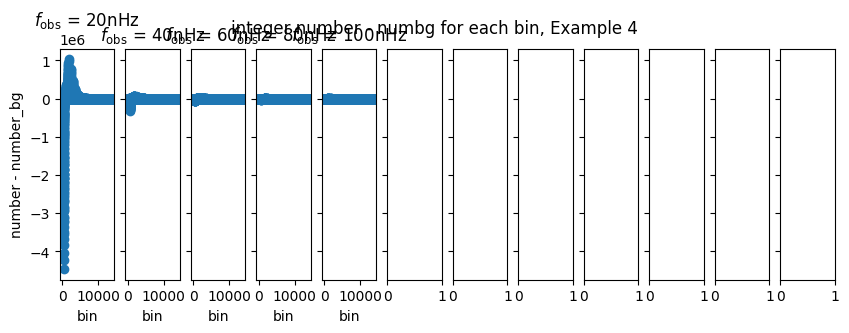

In [411]:
number_test(rounded, bgnum, fobs=fobs, exname= exname)

(5, 4)
(24, 24, 24, 5)
14 23 18 4
15 23 18 3
16 23 18 2
17 23 16 1
20 23 18 0
(24, 24, 24)
(24, 24, 24)


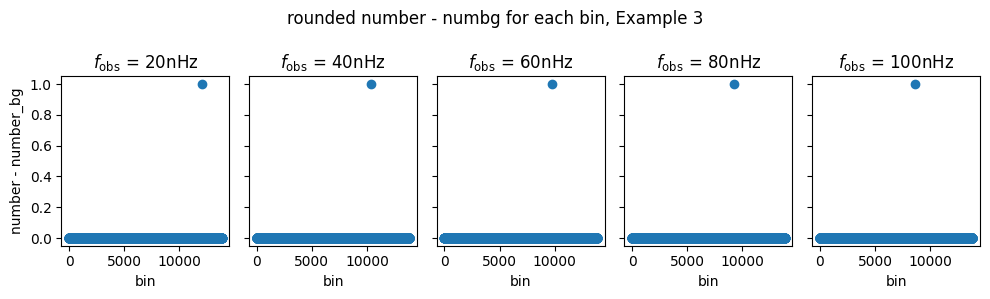

In [139]:
print(ssidx.shape)
print(hsamp.shape)
numbg = np.floor(number).astype(int)
rounded = np.floor(number).astype(int)
# print(numbg%1 == 0)
for ff in range(len(ssidx)):
    m,q,z,f = ssidx[ff]
    print(m,q,z,f)
    numbg[m,q,z,f] -=1

# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
fig.suptitle('rounded number - numbg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (rounded[...,f] - numbg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()

    

In [141]:
difs = rounded-numbg
print(len(difs[0,0,0,:]))
# print(difs[:,:,:,0])
print(np.where(difs==0))
# difs[0,0,0,0] = 2
print(difs[np.where(difs>0)])
print(len(difs[np.where(difs>0)]))
assert len(difs[np.where(difs>0)]) == len(difs[0,0,0,:]), "More than one bin per frequency found with a single source subtracted."

5
(array([ 0,  0,  0, ..., 23, 23, 23], dtype=int64), array([ 0,  0,  0, ..., 23, 23, 23], dtype=int64), array([ 0,  0,  0, ..., 23, 23, 23], dtype=int64), array([0, 1, 2, ..., 2, 3, 4], dtype=int64))
[1 1 1 1 1]
5


sort hsmax with example

In [367]:
edges, number, fobs, exname = example2(False)

In [368]:
hsamp, hsmax, ssidx, bgnum = ss_gws_by_ndars(edges, number, realize=False, round=True, ss=True, sum=True)

In [369]:
run_example_test(edges, number, fobs, exname)

In [352]:
print(hsamp)

hsmaxtest = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
assert np.all(hsmaxtest == hsmax), 'hsmaxtest problem'
print(hsmax)

ssidxtest = np.argwhere(hsamp==hsmaxtest) 
assert np.all(ssidxtest == ssidx), 'ssidx problem'
print(ssidx.shape)
print(ssidx)
for s in range(len(ssidx)):
    print(s)
    m,q,z,f = ssidx[s]
    print(m,q,z,f, hsamp[m,q,z,f])

# This works perfectly for my test grid, so why the actual fuck 
# is it not working for the real hsamps
# I AM LOSING MY MIND

[[[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [3.05e-20 4.84e-20 6.34e-20 7.68e-20 9.21e-20]
   [4.45e-21 9.00e-18 9.26e-21 1.12e-20 1.34e-20]]]


 [[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]
   [2.07e-19 3.28e-19 4.30e-19 5.21e-19 6.24e-19]]]]


AssertionError: hsmaxtest problem

In [351]:
# now modify example:
print(hsamp[0,0,2,1]) # initially 4.83e-20, then set to larger number
hsamp[0,0,2,1] = 9e-18
print(hsamp[0,0,2,1])


7.067344217243042e-21
9e-18


In [359]:
# print(hsamp)

hsmaxtest = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
# print(hsmaxtest)

ssidxtest = np.argwhere(hsamp==hsmaxtest) 
# assert np.all(ssidxtest == ssidx), 'ssidx problem'
print(ssidxtest.shape)
# print(ssidxtest)
for s in range(len(ssidx)):
    print(s)
    m,q,z,f = ssidxtest[s]
    print(m,q,z,f, hsamp[m,q,z,f])

# EUREKA! np.argwhere sorted by max, not np.amax

(5, 4)
0
0 0 2 1 9e-18
1
1 0 1 0 1.4148696145918927e-18
2
1 0 1 2 2.9430473970402786e-18
3
1 0 1 3 3.565248020561944e-18
4
1 0 1 4 4.273882933282341e-18


In [363]:
ssidx_sorted = ssidxtest[ssidxtest[:,-1].argsort()]
print(ssidx_sorted)
for s in range(len(ssidx_sorted)):
    print(s)
    m,q,z,f = ssidx_sorted[s]
    print(m,q,z,f, hsamp[m,q,z,f], hsmax[s])


[[1 0 1 0]
 [0 0 2 1]
 [1 0 1 2]
 [1 0 1 3]
 [1 0 1 4]]
0
1 0 1 0 1.4148696145918927e-18 1.4148696145918927e-18
1
0 0 2 1 9e-18 2.245965514601012e-18
2
1 0 1 2 2.9430473970402786e-18 2.9430473970402786e-18
3
1 0 1 3 3.565248020561944e-18 3.565248020561944e-18
4
1 0 1 4 4.273882933282341e-18 4.273882933282341e-18


In [289]:
hsmaxes = np.max(hsamp, axis=(0,1,2))
print(hsmaxes) # this orders them from largest to smallest
argwhere = np.argwhere(hsamp==hsmaxes)
for a in range(len(argwhere)):
    print(argwhere[a], hsmaxes[a], hsmax[a])
    print(np.max(hsamp[...,argwhere[a]]))
# print(argwhere)
print(hsmax[0])
print(np.max(hsmax))
print(hsamp[13,23,16,0])


[7.08e-17 2.49e-17 1.22e-17 7.89e-18 5.07e-18]
[14 23 18  4] 7.082030655840575e-17 7.082030655840575e-17


IndexError: index 14 is out of bounds for axis 3 with size 5

In [281]:
sortedargs = argwhere[argwhere[:,-1].argsort()]
print(sortedargs)
maxsorted = np.empty_like(hsmax)
for f_idx in range(len(hsmax)): 
    m,q,z,f = sortedargs[f_idx]
    maxsorted[f_idx] = hsamp[m,q,z,f] 
    print(m,q,z,f, maxsorted[f_idx])
# sortedargwhere = np.argwhere(hsamp == sortedmaxes)
# print(sortedargwhere)

[[20 23 18  0]
 [17 23 16  1]
 [16 23 18  2]
 [15 23 18  3]
 [14 23 18  4]]
20 23 18 0 7.082030655840575e-17
17 23 16 1 2.485427762306846e-17
16 23 18 2 1.2154808211517563e-17
15 23 18 3 7.89165279540453e-18
14 23 18 4 5.070236440195799e-18


In [266]:
print(argwhere[argwhere[:,-1].argsort()])

[[20 23 18  0]
 [17 23 16  1]
 [16 23 18  2]
 [15 23 18  3]
 [14 23 18  4]]


In [252]:
for f_idx in range(len(hsmax)):
    print(f_idx)
    # print(hsamp[ssidx[f_idx,0], ssidx[f_idx,1], ssidx[f_idx,2], ssidx[f_idx,3]])
    print(hsmax[f_idx])
    print(sorted_hsmax)
    # print(np.max(hsamp[...,f_idx]))

0
1.0051787086385068e-16
1
4.3250770488997604e-17
2
1.2332171467578702e-17
3
1.040297297960971e-17
4
5.478025031806371e-18
5
2.966218754178506e-18
6
2.6685858687611787e-18
7
2.5021946566713723e-18
8
1.2282383135442348e-18
9
1.3176122816587554e-18
10
6.732469961608836e-19
11
1.3115139732990947e-18


In [221]:
np.set_printoptions(precision=2)
#### Test hsmax
# for i in range(len(hsmax)):
#     print(np.max(hsamp[...,i]) == hsmax[i])
# print(np.max(hsamp[...,0]))
# print(hsmax)
# print(number>=1)

### Test ssidx
# print(ssidx)
print(ssidx.shape)
for f_idx in range(len(hsamp[0,0,0,:])):
    print(f_idx)
    print(hsamp[ssidx[f_idx,0], ssidx[f_idx,1], ssidx[f_idx,2], ssidx[f_idx,3]])
    print(hsmax[f_idx])
    print(np.max(hsamp[...,f_idx]))
    # Those should all be equal, lets make this into asserts
print(hsamp.shape)
# BUG: ssidx does not give the correct maxes for the more complicated exampleS (3 and 4)

(5, 4)
0
5.070236440195799e-18
7.082030655840575e-17
7.082030655840575e-17
1
7.89165279540453e-18
2.485427762306846e-17
2.485427762306846e-17
2
1.2154808211517563e-17
1.2154808211517563e-17
1.2154808211517563e-17
3
2.485427762306846e-17
7.89165279540453e-18
7.89165279540453e-18
4
7.082030655840575e-17
5.070236440195799e-18
5.070236440195799e-18
(24, 24, 24, 5)


compare to loops

In [473]:
edges, number, fobs, exname = example4(print_test=False)
hc_ss, hsamp, hsmax, ssidx, bgnum = run_example_test(edges, number, fobs, exname, print_test=False)

In [462]:
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, number_bg_loop \
      = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

[]


In [495]:
print(hsmax==maxhs_loop)

[ True  True  True  True  True  True  True  True  True  True  True  True]


In [477]:
print(np.all(bgnum == number_bg_loop))
# print(np.all(ssidx == ssidx_loop))

True
False


C:\Users\emiga\AppData\Local\Temp\ipykernel_13792\2197328468.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.all(ssidx == ssidx_loop))


In [482]:
print(ssidx_loop.shape)
print(ssidx.shape)
for i in range(len(ssidx)):
    print(ssidx[i, 0:3] == ssidx_loop[i])

(12, 3)
(12, 4)
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]


In [475]:
# hc_ss working!!

print(np.isclose(hc_ss, hc_ss_loop, atol=10e-35))
print(np.all(hc_ss == hc_ss_loop))
print(hc_ss - hc_ss_loop)
print(hc_ss)
print(hc_ss_loop)

[ True  True  True  True  True  True  True  True  True  True  True  True]
True
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.01e-16 6.12e-17 2.14e-17 2.08e-17 1.22e-17 7.27e-18 7.06e-18 7.08e-18
 3.68e-18 4.17e-18 2.23e-18 3.28e-18]
[1.01e-16 6.12e-17 2.14e-17 2.08e-17 1.22e-17 7.27e-18 7.06e-18 7.08e-18
 3.68e-18 4.17e-18 2.23e-18 3.28e-18]


In [ ]:
assert (np.all(hsmax == maxhs_loop)), "hsmax by ndars does not match by loops"
assert (np.all(ssidx == ssidx_loop)), "ssidx by ndars does not match by loops"
assert (np.all(bgnum == number_bg_loop)), "bgnum by ndars does not match by loops"
assert (np.all(hc_ss == hc_ss_loop)), "hc_ss by ndars does not match by loops"    


working on hc_ss

In [459]:
edges, number, fobs, exname = example4(print_test=False)
hc_ss, hsamp, hsmax, ssidx, bgnum = run_example_test(edges, number, fobs, exname, print_test=False)


[]


C:\Users\emiga\AppData\Local\Temp\ipykernel_13792\989473113.py:97: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert (np.all(ssidx == ssidx_loop)), "ssidx by ndars does not match by loops"


AssertionError: ssidx by ndars does not match by loops

# 2 Super Simple Example 

## 2.1 Build Model

In [73]:
edges, number, fobs, exname = example2(print_test=True)

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz
edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ])]


## 2.2 Calculate strains

In [74]:
# 1. Get GW Total Strain using gws_by_ndars()
# hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# cleaan
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg  = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True, print_test=True)

INPUTS: edges: 4 
 [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ]), array([5.0e-09, 1.5e-08, 2.5e-08, 3.5e-08, 4.5e-08, 6.0e-08])] 
INPUTS:number: (2, 1, 3, 5) 
 [[[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [8.83e+06 6.46e+05 1.44e+05 5.01e+04 2.78e+04]
   [1.09e+09 8.01e+07 1.79e+07 6.21e+06 3.44e+06]]]


 [[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [1.10e+05 8.05e+03 1.80e+03 6.24e+02 3.46e+02]
   [1.29e+07 9.45e+05 2.11e+05 7.32e+04 4.06e+04]]]] 

noninteger bgum values: []
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+39, d_c = 7.33e+25
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-02
	 m_c = 2.27e+39, d_c = 7.25e+26
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-01
	 m_c = 2.27e+39, d_c = 6.42e+27
BIN mt=5.50e+40, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+40, d_c = 7.33e+25
BIN mt=5.50e+40, mr=5.50e-01, rz=5.50e-02
	 m_c = 2.27e+40, d_c = 7.25e+26
BIN mt=5.50e+40, mr=5.50e-01, rz=5.50e-01
	 m_c = 2.27e+40, d_c = 6.42e+27
	fr = 10.06nHz,

In [ ]:
hc_bg2, hc_ss2, sspar2, ssidx2, maxhs2, number_bg2 = ss_gws_by_loops_2(edges, number, realize=False, round=True, sum=True, ss=True, print_test=True)

INPUTS: edges: 4 
 [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.001, 0.01 , 0.1  , 1.   ]), array([5.0e-09, 1.5e-08, 2.5e-08, 3.5e-08, 4.5e-08, 6.0e-08])] 
INPUTS:number: (2, 1, 3, 5) 
 [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [8.82745690e+06 6.46423553e+05 1.44416576e+05 5.00858751e+04
    2.77638151e+04]
   [1.09390698e+09 8.01054307e+07 1.78962414e+07 6.20668998e+06
    3.44051876e+06]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]
   [1.09892126e+05 8.04726202e+03 1.79782747e+03 6.23514038e+02
    3.45628951e+02]
   [1.28993591e+07 9.44603826e+05 2.11032610e+05 7.31893338e+04
    4.05706225e+04]]]] 

BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+39, d_c = 7.33e+25
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-02
	 m_c = 2.27e+39, d_c = 7.25e+26
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-01
	 m_c = 2.27e+39, d_c = 6.42e+27
BIN mt=5.50e+40, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+40,

In [ ]:
print(np.all(hc_ss == hc_ss2))
print(np.all(hc_bg == hc_bg2))
np.allclose(hc_bg, hc_bg2)
print(hc_ss - hc_ss2)

True
True
[0. 0. 0. 0. 0.]


## 2.3 Test Plots

### BG, SS, and TT Strain

5


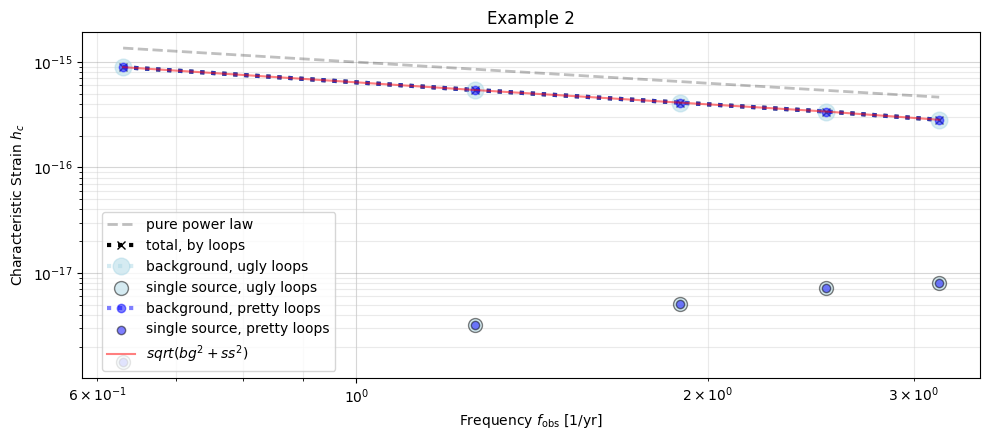

In [ ]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR
print(len(hc_bg_ugly))

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')

# gwb
ax.plot(xx, hc_bg_ugly, color='lightblue', marker = 'o', lw=3, ms=12,
        ls = 'dotted', alpha=.5, label='background, ugly loops')
# loudest source per bin
ax.scatter(xx, hc_ss_ugly, color='lightblue', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, ugly loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = 'o', lw=3, ls = 'dotted', alpha=.5, label='background, pretty loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.5, label='single source, pretty loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(2, 1, 3)
(2, 1, 3)


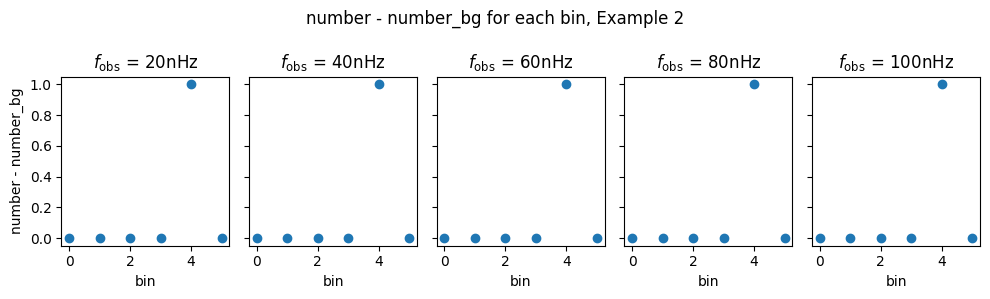

In [ ]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (number[...,f] - number_bg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


# 3 Slightly More Complex Example
Let's see what windows can handle. Limiting factor seems to be the total mass upper limit.

In [206]:
exname = 'Example 3'

## 3.1 Build Model

In [241]:
edges, number, fobs, exname = example3()

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz
edges: [array([1.00e+39, 1.45e+39, 2.11e+39, 3.07e+39, 4.47e+39, 6.50e+39,
       9.44e+39, 1.37e+40, 2.00e+40, 2.90e+40, 4.22e+40, 6.13e+40,
       8.92e+40, 1.30e+41, 1.89e+41, 2.74e+41, 3.98e+41, 5.79e+41,
       8.42e+41, 1.22e+42, 1.78e+42, 2.59e+42, 3.76e+42, 5.47e+42,
       7.95e+42]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


## 3.2 Calculate strains

### Test SS Steps

In [210]:
hsamp, hsmax, ssidx, bgnum = ss_gws_by_ndars(edges, number, realize=False, round=True, ss=True, sum=True)
# (hsmax, hsamp) # argwhere should work!
run_example_test(edges, number,fobs, exname)

In [44]:
bgnum = np.copy(np.floor(number).astype(int))

In [ ]:
# 1. Get GW Total Strain using gws_by_ndars()
# hc_tt = ss_gws_by_loops(edges, number, realize=False, round = True, sum=True, ss=False)   
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)  
 
# 2 Get bg (background) and ss (single source) strains by ss_gws_by_loops
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

number: 1382.6293730910595
number: 101.24820798390314
number: 22.619719522648033
number: 7.844864359605974
number: 4.348598543025433
number: 1405.846235660716
number: 102.9483495951948
number: 22.99954576512647
number: 7.97659390423975
number: 4.421619423898459
number: 1432.1804170893527
number: 104.87676854120026
number: 23.430371125391
number: 8.1260107221879
number: 4.5044447892646815
number: 1462.0094080819626
number: 107.06110799090965
number: 23.918371324886255
number: 8.29525664801239
number: 4.598261909958701
number: 1495.7639851229476
number: 109.53291316384173
number: 24.47059383666882
number: 8.48677585305459
number: 4.704425649423246
number: 1533.9369558204683
number: 112.32827174059858
number: 25.095100958627178
number: 8.703364465414081
number: 4.824485969266647
number: 1577.0935268293033
number: 115.48857309280112
number: 25.801139431972125
number: 8.948229396232904
number: 4.960220538098661
number: 1625.8836218263855
number: 119.06141031292692
number: 26.599341962452197

In [ ]:
print(np.all(np.abs(number_bg-number_bg3)<=2))

True


### figuring out loops2 method

In [ ]:
hc_bg2, hc_ss2, sspar2, ssidx2, maxhs2, number_bg2 = ss_gws_by_loops_2(edges, number, realize=False, round=True, sum=True, ss=True)

[]


In [ ]:
print(hc_bg2)

[9.13066264e-16 3.49961493e-16 1.83334578e-16 1.10513747e-16
 7.76726695e-17]


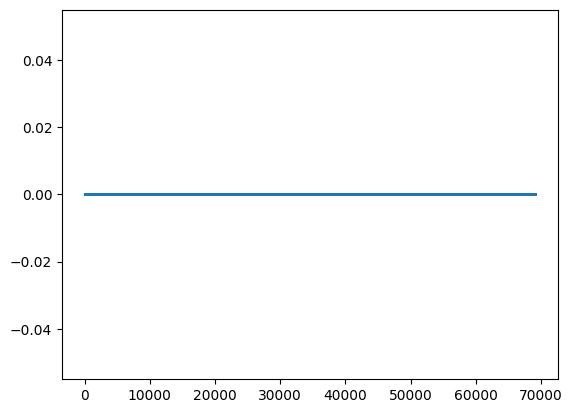

In [ ]:
plt.scatter(np.arange(0, number_bg.size, 1), (number_bg - number_bg2).flatten(), s=.5)

In [ ]:
print(number_bg[np.where(number_bg%1 != 0)])

[]


In [ ]:
unmatched = np.where(number_bg-number_bg2 >0)
print(number_bg2[unmatched])

[]


In [ ]:
print(np.all(hc_bg == hc_bg2))
print(np.all(hc_ss == hc_ss2))
print(np.all(sspar == sspar2))
print(np.all(ssidx == ssidx2))
print(np.all(number_bg == number_bg2))

True
True
True
True
True


In [ ]:
np.isclose(hc_ss2, hc_ss)

array([ True,  True,  True,  True,  True])

In [ ]:
test = (hc_bg2**2 + hc_ss2**2)
error = (test-hc_tt**2)/hc_tt**2
# np.isclose(hc_tt, )
print(error)
print(hc_tt - np.sqrt(hc_ss2**2 + hc_bg2**2))

[-2.08848403e-16 -3.53981910e-16 -4.82207307e-16  2.19613463e-16
  4.46987181e-16]
[ 0.00000000e+00  4.93038066e-32  4.93038066e-32  0.00000000e+00
 -1.23259516e-32]


## 3.3 Test Plots

### BG, SS, and TT Strain

(5,)


NameError: name 'hc_tt' is not defined

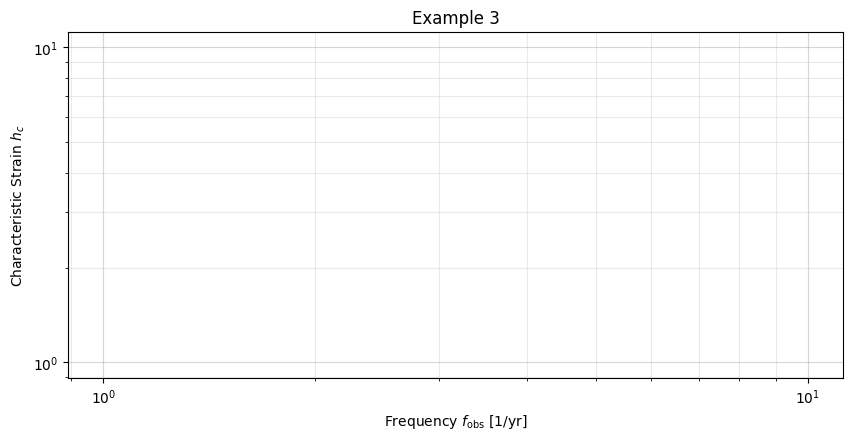

In [ ]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR
print(fobs.shape)
print(len(hc_tt))
# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = 'o', lw=3, ls = 'dotted', alpha=.5, label='background, pretty loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.5, label='single source, pretty loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(24, 24, 24)
(24, 24, 24)


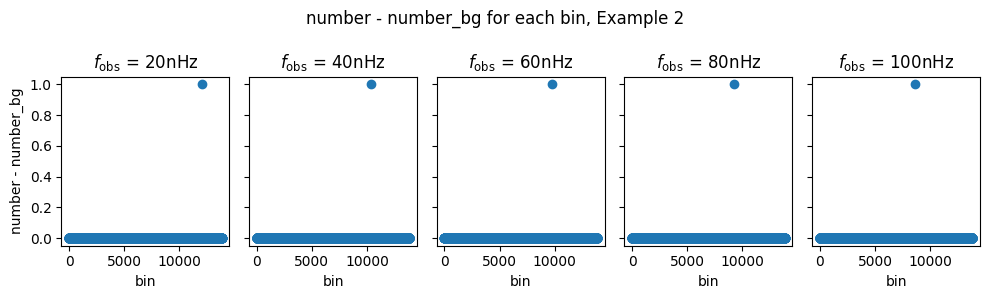

In [165]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (np.floor(number[...,f]).astype(int) - numbg[...,f]))
    # ax[f].scatter(bins, ((number[...,f]) - numbg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


# 4 Even More Complex Example - Casting 64bit


## 4.1 Build Model

In [242]:
edges, number, fobs, exname = example4()

Number of frequency bins: 11
  between [0.63, 7.57] 1/yr
          [20.00, 240.00] nHz
edges: [array([1.00e+39, 1.76e+39, 3.10e+39, 5.46e+39, 9.63e+39, 1.70e+40,
       2.99e+40, 5.26e+40, 9.27e+40, 1.63e+41, 2.87e+41, 5.06e+41,
       8.92e+41, 1.57e+42, 2.77e+42, 4.87e+42, 8.58e+42, 1.51e+43,
       2.66e+43, 4.69e+43, 8.26e+43, 1.46e+44, 2.56e+44, 4.52e+44,
       7.95e+44]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


## 4.2 Calculate strains

### Test SS Steps

In [110]:
hsamp, hsmax, ssidx, bgnum = ss_gws_by_ndars(edges, number, realize=False, round=True, ss=True, sum=True)
test_max_indices(hsmax, hsamp) # argwhere should work!

ValueError: not enough values to unpack (expected 4, got 3)

In [339]:
argwhere1 = np.argwhere(hsamp==hsmax)
argwhere2 = np.argwhere(hsmax==hsamp)
np.all(argwhere1==argwhere2)
print(argwhere1.shape)
print(argwhere1)
# for f_idx in range(12):
#     hsmax[]

(12, 4)
[[ 6 23 16 10]
 [ 7 23 17  8]
 [ 7 23 17  9]
 [ 7 23 18 11]
 [ 8 23 16  5]
 [ 8 23 17  6]
 [ 8 23 18  7]
 [ 9 23 17  4]
 [10 23 16  2]
 [10 23 18  3]
 [12 23 18  1]
 [13 23 16  0]]


In [ ]:
# 1. Get GW Total Strain using gws_by_ndars()
# hc_tt = gws_by_loops(edges, number, realize=False, round = True, sum=True)   
 
# 2 Get bg (background) and ss (single source) strains by ss_gws_by_loops
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

In [ ]:
hc_bg2, hc_ss2, sspar2, ssidx2, maxhs2, number_bg2 = ss_gws_by_loops_2(edges, number, realize=False, round=True, sum=True, ss=True)

In [ ]:
print(np.all(hc_ss == hc_ss2))
print(np.all(hc_bg == hc_bg2))
np.allclose(hc_bg, hc_bg2)
print((hc_ss - hc_ss2)/hc_ss)

False
False
[  -122179.57734332   -450751.62972327  -2071507.57709187
  -2974823.2357648   -6555432.92611585 -13671297.87519651
 -16840808.58163318 -19632894.40679266 -43263781.46830584
 -43263781.46830586 -90226230.7433109  -50436607.28686279]


## 4.3 Test Plots

### BG, SS, and TT Strain

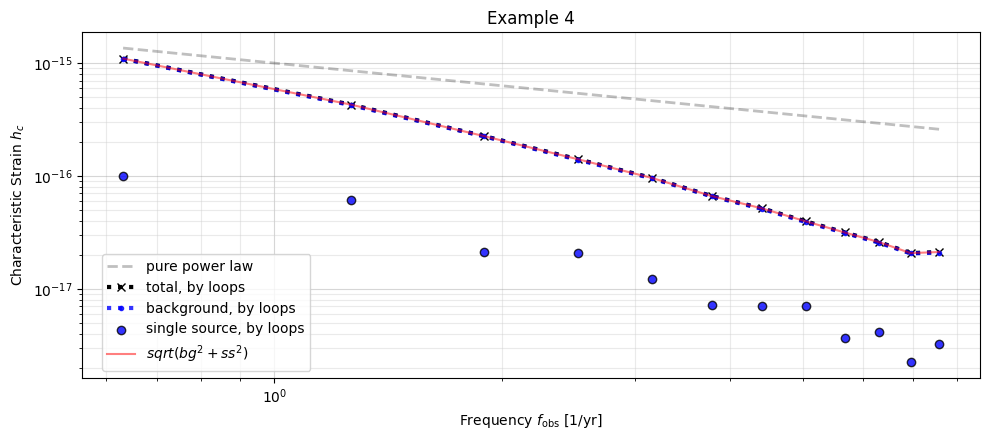

In [ ]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = '.', lw=3, ls = 'dotted', alpha=.8, label='background, by loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.8, label='single source, by loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss')
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(24, 24, 24)
(24, 24, 24)


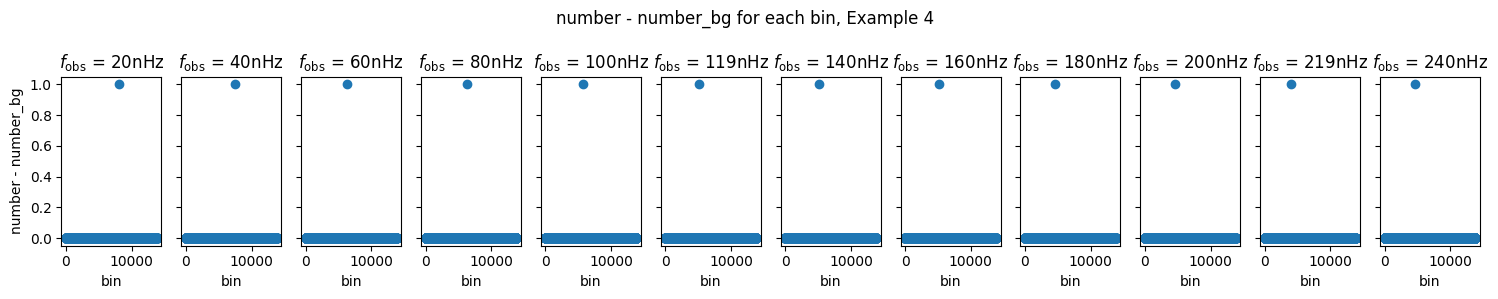

In [ ]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (15,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (number[...,f] - number_bg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


In [ ]:
test = (hc_bg**2 + hc_ss**2)
error = (test-hc_tt**2)/hc_tt**2
# np.isclose(hc_tt, )
print(error)
print(hc_tt - np.sqrt(hc_ss**2 + hc_bg**2))

[ 0.00e+00 -2.38e-16 -2.15e-16 -1.39e-16 -2.96e-16  1.55e-16 -1.28e-16
  2.18e-16 -1.71e-16  0.00e+00  0.00e+00  1.90e-16]
[ 0.00e+00  4.93e-32  0.00e+00  0.00e+00  1.23e-32  0.00e+00  0.00e+00
 -6.16e-33  0.00e+00  0.00e+00  0.00e+00  0.00e+00]


use n>0